# Tutorial 2: Source Classification
https://astronomers.skatelescope.org/ska-science-data-challenge-1/

The last tutorial gave us two data frames, one used to train the machine learning model and the other to test the trained model. This notebook will go through the following:

    - Data exploration
    - Data pre_processing
    - Training
    - Testing

For this tutorial, we have three kinds of astronomical sources, namely star-forming galaxies (`SFGs`), steep-spectrum (`SS`) AGN, and flat-spectrum (`FS`) AGN. The primary purpose is to use features from Pydsf to classify astronomical sources.

---

First, let us recall the data from the previous notebook

In [1]:
%store -r sources_training_1400
%store -r sources_full_1400

#### Examining data

First let's take a look at the raw data

In [2]:
sources_training_1400[1400]

,Source_id,Isl_id,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,...,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,n_gaussians
0,0,0,359.999746,0.000014,-29.856456,0.000011,9.947102e-07,1.908813e-07,6.020551e-07,7.738053e-08,...,64.362563,25.682843,5.253248e-07,8.197129e-08,7.220221e-08,-3.125654e-08,1.380381e-08,-3.114713e-08,S,1
1,1,1,359.999413,0.000017,-29.828395,0.000009,4.765558e-06,4.187382e-07,9.121587e-07,6.799415e-08,...,104.110879,8.138976,3.112229e-06,1.788294e-07,7.380012e-08,-2.670467e-08,9.398234e-08,-4.783774e-08,S,1
2,2,2,359.999746,0.000005,-29.794905,0.000009,2.980899e-06,2.660662e-07,1.288173e-06,8.365145e-08,...,10.713707,8.554466,1.931456e-06,1.303469e-07,7.901944e-08,-2.435674e-08,1.658425e-08,-2.374887e-08,S,1
3,3,5,359.999732,0.000006,-29.740689,0.000005,1.489622e-06,1.745461e-07,1.260154e-06,8.997610e-08,...,53.702714,70.682121,1.216590e-06,1.228672e-07,8.677247e-08,-9.041280e-09,7.439110e-09,-9.216460e-09,S,1
4,4,6,359.999559,0.000023,-29.732342,0.000012,2.598173e-06,3.844502e-07,7.295256e-07,8.591499e-08,...,76.401510,12.657255,1.788939e-06,1.567520e-07,8.636927e-08,-6.577470e-09,3.864574e-08,-6.473210e-09,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6713,6713,6629,359.731508,0.000012,-29.876898,0.000009,1.106944e-06,1.990343e-07,7.408404e-07,8.627216e-08,...,62.546396,17.522848,8.364963e-07,1.611191e-07,8.193609e-08,-3.458156e-08,1.135522e-08,-3.466038e-08,S,1
6714,6714,6630,359.731638,0.000005,-29.758883,0.000008,5.810244e-06,3.446668e-07,2.177925e-06,9.564250e-08,...,149.059959,3.726750,4.671508e-06,2.152728e-07,9.755728e-08,-6.453270e-09,6.726988e-08,-2.335470e-09,S,1
6715,6715,6631,359.731357,0.000014,-29.893082,0.000024,1.267585e-06,2.766859e-07,5.512391e-07,8.698541e-08,...,156.735241,17.127312,6.344469e-07,1.183303e-07,8.356837e-08,-4.278501e-08,2.107820e-09,-4.278609e-08,S,1
6716,6716,6632,359.731581,0.000004,-29.791127,0.000004,2.222179e-06,1.891976e-07,1.809841e-06,9.493669e-08,...,9.110768,24.449253,2.107202e-06,1.501826e-07,9.104431e-08,-1.199970e-08,3.211200e-08,-1.223132e-08,S,1


We may verify the shape of the data frame:

In [3]:
print(sources_training_1400[1400].shape)

(6718, 46)


The data frame above, in its current state, is not suited to be used for ML for the following reasons: 
   * Some columns need to be excluded, like Source_ID,...
   * Perform cross matching aginst the truth catalog and get the matched output (meaning get all actual sources where Pydsf correctly identified sources.
   * Include the matched output from Pydsf (ground truth) to perform supervised learning.
   
   In conclusion, we will need to perform some pre-processing on the data frame provided by Pydsf

---

#### Data pre-processing

Importing some libraries:

In [4]:
from source.utils.bdsf_utils import  load_truth_df, cat_df_from_srl_df 
from source.path import train_truth_path, full_truth_path, write_df_to_disk, submission_df_path
from source.utils.columns import SRL_CAT_COLS, SRL_COLS_TO_DROP, SRL_NUM_COLS
from source.utils.classification import SKLClassification

In [5]:
model_pre = SKLClassification()
train_truth_cat_df = load_truth_df(train_truth_path(1400), skiprows=18) # the tuth cataluge for the training data

"""
Args:
    srl_df (:obj:`pandas.DataFrame`): Source list.
    truth_cat_df (:obj:`pandas.DataFrame`): Truth catalogue.
    regressand_col: (`str`): Regressand column name (output).
    freq: (`int`): Frequency band (MHz).
Returns:
    srl_df (`str`): Crossmatched source list DataFrame used for training.
"""
train_df = model_pre.pre_process(sources_training_1400[1400], train_truth_cat_df, regressand_col="class_t", freq=1400)

2025-03-21 10:59:30,258 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 10:59:30,259 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 10:59:30,341 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.08s
2025-03-21 10:59:30,740 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.40s
2025-03-21 10:59:30,741 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.48s
2025-03-21 10:59:30,775 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.52s
2025-03-21 10:59:30,823 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.56s
2025-03-21 10:59:30,824 [MainThread  ][INFO ] Final score: 4769.72


---

#### Examining the traning data

In [6]:
train_df

,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,Maj,E_Maj,Min,E_Min,Maj_img_plane,E_Maj_img_plane,...,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,n_gaussians,class_t
Source_id,,,,,,,,,,,,,,,,,,,,,
0,9.947102e-07,1.908813e-07,6.020551e-07,7.738053e-08,0.000241,0.000034,0.000191,0.000022,0.000241,0.000034,...,25.682843,5.253248e-07,8.197129e-08,7.220221e-08,-3.125654e-08,1.380381e-08,-3.114713e-08,2,1.0,3.0
1,4.765558e-06,4.187382e-07,9.121587e-07,6.799415e-08,0.000505,0.000041,0.000287,0.000020,0.000505,0.000041,...,8.138976,3.112229e-06,1.788294e-07,7.380012e-08,-2.670467e-08,9.398234e-08,-4.783774e-08,2,1.0,3.0
2,2.980899e-06,2.660662e-07,1.288173e-06,8.365145e-08,0.000309,0.000023,0.000208,0.000012,0.000309,0.000023,...,8.554466,1.931456e-06,1.303469e-07,7.901944e-08,-2.435674e-08,1.658425e-08,-2.374887e-08,2,1.0,3.0
3,1.489622e-06,1.745461e-07,1.260154e-06,8.997610e-08,0.000185,0.000013,0.000177,0.000012,0.000185,0.000013,...,70.682121,1.216590e-06,1.228672e-07,8.677247e-08,-9.041280e-09,7.439110e-09,-9.216460e-09,2,1.0,3.0
4,2.598173e-06,3.844502e-07,7.295256e-07,8.591499e-08,0.000414,0.000055,0.000239,0.000025,0.000414,0.000055,...,12.657255,1.788939e-06,1.567520e-07,8.636927e-08,-6.577470e-09,3.864574e-08,-6.473210e-09,2,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6713,1.106944e-06,1.990343e-07,7.408404e-07,8.627216e-08,0.000240,0.000032,0.000173,0.000018,0.000240,0.000032,...,17.522848,8.364963e-07,1.611191e-07,8.193609e-08,-3.458156e-08,1.135522e-08,-3.466038e-08,2,1.0,3.0
6714,5.810244e-06,3.446668e-07,2.177925e-06,9.564250e-08,0.000404,0.000022,0.000184,0.000006,0.000404,0.000022,...,3.726750,4.671508e-06,2.152728e-07,9.755728e-08,-6.453270e-09,6.726988e-08,-2.335470e-09,2,1.0,3.0
6715,1.267585e-06,2.766859e-07,5.512391e-07,8.698541e-08,0.000327,0.000060,0.000195,0.000026,0.000327,0.000060,...,17.127312,6.344469e-07,1.183303e-07,8.356837e-08,-4.278501e-08,2.107820e-09,-4.278609e-08,2,1.0,3.0


Now let us check the frequencies of the astronomical sources.

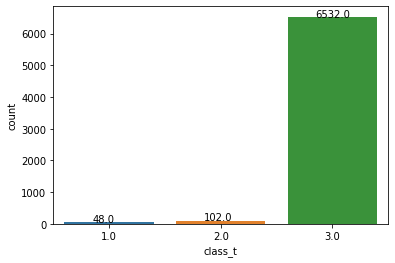

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x="class_t",data=train_df)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.savefig("1400_MHz")
plt.show()

Where:
   - Class 1 ->   SS-AGN
   - Class 2 ->   FS-AGN
   - Class 3 ->   SFG

I have been asking myself why there is a majority of SFGs in the simulated data. If you do not know, ask the nearest postdoc you see.

**Exercise 1:** Clean and visualise the other 2 frequencies 
<br>

---

### Training

First, let us separate the data frame into input and output

In [8]:
from sklearn.utils import shuffle
 
train_df = shuffle(train_df) # we are shuffling the data.
train_x = train_df.drop(['class_t'], axis = 1) # input data
train_y = train_df['class_t'] # output data

In [9]:
print("Input dim "+ str(train_x.shape)) # input
print("output dim: "+ str(train_y.shape)) # output

Input dim (6682, 34)
output dim: (6682,)


In this notebook, we will use Random Forest to classify the 3 classes above

In [10]:
from sklearn.ensemble import RandomForestClassifier # a ML model
from sklearn.metrics import classification_report # this package is used to assess the accuracy of the ML models


In [11]:
forest = RandomForestClassifier(random_state=0)
forest.fit(train_x, train_y) # train the ML model on the training data

RandomForestClassifier(random_state=0)

We can try and assess the model aginst the training data

In [12]:
y_pred = forest.predict(train_x)

In [13]:
print(classification_report (train_y, y_pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        48
         2.0       1.00      1.00      1.00       102
         3.0       1.00      1.00      1.00      6532

    accuracy                           1.00      6682
   macro avg       1.00      1.00      1.00      6682
weighted avg       1.00      1.00      1.00      6682



The score is 100% accurate, which is expected since the trained model has seen the data before. Now let us test it against the whole catalog (test set) without the training data.

**Exercise 2:** train the other 2 frequencies on their training data 
<br>

---

### Testing

In [14]:
sources_full_1400[1400]["class"] = model_pre.test(forest, sources_full_1400[1400]) # add the predicted output to the source df

/shared/venv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [15]:
sources_full_1400[1400]

,Source_id,Isl_id,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,...,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,n_gaussians,class
0,0,0,0.066975,0.000004,-29.932994,0.000005,0.000002,1.572058e-07,1.357248e-06,7.493803e-08,...,14.655325,1.279678e-06,9.347710e-08,7.130576e-08,-3.632804e-08,1.249534e-08,-3.580807e-08,S,1,3.0
1,1,1,0.066921,0.000002,-29.922052,0.000001,0.000011,2.019120e-07,5.869066e-06,7.136677e-08,...,1.210857,9.331264e-06,1.401998e-07,6.879522e-08,-3.488933e-08,6.091204e-08,-2.236411e-08,S,1,3.0
2,2,3,0.065637,0.000001,-29.829974,0.000001,0.000101,7.654782e-07,1.724094e-05,9.476611e-08,...,0.340845,2.393138e-04,1.145924e-06,9.476611e-08,-2.333695e-08,9.284529e-07,8.610156e-07,M,2,3.0
3,3,3,0.064335,0.000008,-29.829784,0.000006,0.000014,5.335616e-07,2.581821e-06,8.411465e-08,...,2.899619,2.393138e-04,1.145924e-06,9.476611e-08,-2.333695e-08,9.284529e-07,8.610156e-07,C,1,3.0
4,4,3,0.064787,0.000004,-29.829553,0.000003,0.000003,2.160466e-07,2.492972e-06,1.004591e-07,...,17.254079,2.393138e-04,1.145924e-06,9.476611e-08,-2.333695e-08,9.284529e-07,8.610156e-07,C,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15008,15008,14806,359.664393,0.000007,-29.915872,0.000017,0.000001,2.333825e-07,8.151265e-07,9.655394e-08,...,12.188527,1.006865e-06,1.467951e-07,9.407992e-08,-3.729318e-08,2.805277e-08,-4.351373e-08,S,1,3.0
15009,15009,14807,359.664226,0.000001,-29.912475,0.000002,0.000008,2.369456e-07,4.881310e-06,9.624837e-08,...,3.411056,7.680536e-06,1.993283e-07,9.033154e-08,-2.896639e-08,5.851238e-08,-2.290315e-08,S,1,3.0
15010,15010,14808,359.664025,0.000011,-29.944404,0.000010,0.000002,2.672098e-07,9.496009e-07,1.020136e-07,...,21.340794,1.176509e-06,1.644092e-07,9.480396e-08,-4.284234e-08,3.574302e-08,-4.136313e-08,S,1,3.0
15011,15011,14809,359.664421,0.000018,-29.813855,0.000014,0.000003,4.030820e-07,9.296596e-07,1.084887e-07,...,12.903024,1.748508e-06,1.647595e-07,1.055932e-07,-9.917890e-09,1.863867e-08,-9.637060e-09,S,1,3.0


In [16]:
from source.path import full_truth_path, write_df_to_disk, submission_df_path, score_report_path, image_path
from ska_sdc import Sdc1Scorer
import os
from pathlib import Path


In [17]:
# 6) Create final catalogues and calculate scores
print("\nStep 6: Final score")
for freq, source_df in sources_full_1400.items():
    # Assemble submission and truth catalogues for scoring
    sub_cat_df = cat_df_from_srl_df(source_df, guess_class=False)
    truth_cat_df = load_truth_df(full_truth_path(freq), skiprows=0)
    
    # (Optional) Write final submission catalogue to disk
    write_df_to_disk(sub_cat_df, submission_df_path(freq))

    # Calculate score
    scorer = Sdc1Scorer(sub_cat_df, truth_cat_df, freq)
    score = scorer.run(mode=0, train=False, detail=True) # train=False -> means that we are removing the training data from the evaluation, so there is no data leakage

    # Write short score report:
    score_path = score_report_path(freq)
    score_dir = os.path.dirname(score_path)
    Path(score_dir).mkdir(parents=True, exist_ok=True)

    with open(score_path, "w+") as report:
        report.write(
            "Image: {}, frequency: {} MHz\n".format(image_path(freq), freq)
        )
        report.write("Score was {}\n".format(score.value))
        report.write("Number of detections {}\n".format(score.n_det))
        report.write("Number of matches {}\n".format(score.n_match))
        report.write(
            "Number of matches too far from truth {}\n".format(score.n_bad)
        )
        report.write("Number of false detections {}\n".format(score.n_false))
        report.write("Score for all matches {}\n".format(score.score_det))
        report.write("Accuracy percentage {}\n".format(score.acc_pc))
        report.write("Classification report: \n")
        report.write(
            classification_report(
                score.match_df["class_t"],
                score.match_df["class"],
                labels=[1, 2, 3],
                target_names=["1 (SS-AGN)", "2 (FS-AGN)", "3 (SFG)"],
                digits=4,
            )
        )

print("\nComplete")


Step 6: Final score


2025-03-21 10:59:38,392 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 10:59:38,393 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 10:59:39,360 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.97s
2025-03-21 10:59:41,458 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 2.10s
2025-03-21 10:59:41,460 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 3.07s
2025-03-21 10:59:41,495 [MainThread  ][INFO ] Sieving complete. Elapsed time: 3.10s
2025-03-21 10:59:41,543 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 3.15s
2025-03-21 10:59:41,544 [MainThread  ][INFO ] Final score: 5849.64



Complete


/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Your results can be found in:
`data/score/1400mhz_score.txt`

---

## Now it is your turn
 - on the other two frequencies, show us the following:
     - The images before and after clipping
     - Before and after PB correction
     - training image
- on all three training data frames ( from the three frequencies):
     - Try to improve/add to the pipeline we introduced on the training data. Maybe you can try [feature reduction](https://scikit-learn.org/stable/modules/feature_selection.html).
     - Try more [ML models](https://scikit-learn.org/stable/supervised_learning.html)
- Make a comparison between all three frequencies 
- Present the results

## Trying more models

In [69]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier  # a ML model
import os
from pathlib import Path

# List of classifiers to be used
classifiers = {
    "RandomForest": RandomForestClassifier(random_state=0),
    "SVM": SVC(random_state=0),
    "GradientBoosting": GradientBoostingClassifier(random_state=0),
    "NaiveBayes": GaussianNB()
}

# Process each classifier
for classifier_name, classifier in classifiers.items():
    print(f"\nTraining {classifier_name} Classifier")

    # Train the classifier
    classifier.fit(train_x, train_y)

    # Make predictions and add to the source dataframe
    sources_full_1400[1400]["class"] = model_pre.test(classifier, sources_full_1400[1400])

    # Evaluate the classifier
    y_pred = classifier.predict(train_x)
    print(f"Classification Report for {classifier_name}:\n")
 #   print(classification_report(train_y, y_pred))

    # Save the results (score calculation and report writing)
    for freq, source_df in sources_full_1400.items():
        # Assemble submission and truth catalogues for scoring
        sub_cat_df = cat_df_from_srl_df(source_df, guess_class=False)
        truth_cat_df = load_truth_df(full_truth_path(freq), skiprows=0)

        # (Optional) Write final submission catalogue to disk
        write_df_to_disk(sub_cat_df, submission_df_path(freq))

        # Calculate score
        scorer = Sdc1Scorer(sub_cat_df, truth_cat_df, freq)
        score = scorer.run(mode=0, train=False, detail=True)  # train=False -> removing the training data

        # Write short score report:
        # Combine `freq`, `classifier_name`, and some other relevant information to create a unique score path
        score_path = score_report_path(f"{freq}_{classifier_name}")  # Concatenate freq and classifier_name
        score_dir = os.path.dirname(score_path)
        Path(score_dir).mkdir(parents=True, exist_ok=True)

        with open(score_path, "w+") as report:
            report.write(
                f"Image: {image_path(freq)}, frequency: {freq} MHz\n"
            )
            report.write(f"Classifier: {classifier_name}\n")  # Added classifier name to the report
            report.write(f"Score was {score.value}\n")
            report.write(f"Number of detections {score.n_det}\n")
            report.write(f"Number of matches {score.n_match}\n")
            report.write(f"Number of matches too far from truth {score.n_bad}\n")
            report.write(f"Number of false detections {score.n_false}\n")
            report.write(f"Score for all matches {score.score_det}\n")
            report.write(f"Accuracy percentage {score.acc_pc}\n")
            report.write("Classification report: \n")
            report.write(
                classification_report(
                    score.match_df["class_t"],
                    score.match_df["class"],
                    labels=[1, 2, 3],
                    target_names=["1 (SS-AGN)", "2 (FS-AGN)", "3 (SFG)"],
                    digits=4,
                )
            )

print("\nComplete")



Training RandomForest Classifier


/shared/venv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Classification Report for RandomForest:



2025-03-21 13:05:41,860 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 13:05:41,861 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 13:05:42,744 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.88s
2025-03-21 13:05:44,953 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 2.21s
2025-03-21 13:05:44,956 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 3.09s
2025-03-21 13:05:44,991 [MainThread  ][INFO ] Sieving complete. Elapsed time: 3.13s
2025-03-21 13:05:45,038 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 3.18s
2025-03-21 13:05:45,038 [MainThread  ][INFO ] Final score: 5851.50
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shar


Training SVM Classifier
Classification Report for SVM:



2025-03-21 13:05:48,167 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 13:05:48,168 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 13:05:49,067 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.90s
2025-03-21 13:05:51,270 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 2.20s
2025-03-21 13:05:51,272 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 3.10s
2025-03-21 13:05:51,307 [MainThread  ][INFO ] Sieving complete. Elapsed time: 3.14s
2025-03-21 13:05:51,354 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 3.19s
2025-03-21 13:05:51,355 [MainThread  ][INFO ] Final score: 5852.78
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shar


Training GradientBoosting Classifier
Classification Report for GradientBoosting:



2025-03-21 13:05:54,512 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 13:05:54,513 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 13:05:55,539 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 1.03s
2025-03-21 13:05:57,725 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 2.19s
2025-03-21 13:05:57,728 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 3.21s
2025-03-21 13:05:57,763 [MainThread  ][INFO ] Sieving complete. Elapsed time: 3.25s
2025-03-21 13:05:57,810 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 3.30s
2025-03-21 13:05:57,810 [MainThread  ][INFO ] Final score: 5852.78
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shar


Training NaiveBayes Classifier
Classification Report for NaiveBayes:



2025-03-21 13:06:00,989 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 13:06:00,990 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 13:06:01,894 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.90s
2025-03-21 13:06:04,076 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 2.18s
2025-03-21 13:06:04,078 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 3.09s
2025-03-21 13:06:04,113 [MainThread  ][INFO ] Sieving complete. Elapsed time: 3.12s
2025-03-21 13:06:04,160 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 3.17s
2025-03-21 13:06:04,160 [MainThread  ][INFO ] Final score: 5801.21



Complete


/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 560 MHz Image Analysis

In [19]:
%store -r sources_training_560
%store -r sources_full_560

In [20]:
sources_training_560[560]

,Source_id,Isl_id,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,...,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,n_gaussians
0,0,2,359.998408,0.000012,-29.788556,0.000012,0.000013,1.030594e-06,0.000008,4.311656e-07,...,135.577638,11.007319,0.000012,8.212615e-07,4.029877e-07,-2.081018e-07,5.626392e-07,-2.356874e-08,S,1
1,1,5,359.998978,0.000011,-29.699367,0.000009,0.000010,8.362997e-07,0.000008,4.258478e-07,...,87.045857,23.932507,0.000006,5.804168e-07,4.099069e-07,-2.585068e-07,7.211217e-08,-2.569541e-07,S,1
2,2,8,359.997507,0.000001,-29.687341,0.000004,0.000288,3.014932e-06,0.000067,4.344371e-07,...,100.062939,0.466877,0.000278,1.785906e-06,4.344371e-07,-2.617439e-07,3.688416e-07,-2.300531e-07,M,3
3,3,8,359.998545,0.000025,-29.686645,0.000024,0.000004,8.542430e-07,0.000003,4.474416e-07,...,129.704108,50.566247,0.000278,1.785906e-06,4.344371e-07,-2.617439e-07,3.688416e-07,-2.300531e-07,C,1
4,4,12,359.998668,0.000019,-29.483299,0.000019,0.000009,1.146173e-06,0.000006,4.781124e-07,...,103.836729,116.549133,0.000007,7.113402e-07,4.430476e-07,-2.489324e-07,3.549225e-07,-2.149795e-07,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21432,21432,20237,359.329498,0.000025,-29.553424,0.000018,0.000011,1.418005e-06,0.000006,5.565866e-07,...,85.500362,24.281607,0.000006,7.302119e-07,5.156965e-07,-2.541688e-07,1.203402e-07,-2.520912e-07,S,1
21433,21433,20238,359.329947,0.000018,-29.512757,0.000021,0.000007,1.093333e-06,0.000005,5.255509e-07,...,179.901957,44.223496,0.000005,7.065773e-07,4.990051e-07,-2.267064e-07,5.448424e-08,-2.266217e-07,S,1
21434,21434,20239,359.329851,0.000014,-29.505397,0.000012,0.000012,1.142182e-06,0.000009,5.329211e-07,...,80.402918,24.339693,0.000007,7.126596e-07,5.033006e-07,-2.359353e-07,2.814955e-08,-2.359036e-07,S,1
21435,21435,20240,359.330350,0.000025,-29.447631,0.000018,0.000006,1.025330e-06,0.000005,5.360393e-07,...,0.000000,28.114285,0.000004,7.128200e-07,5.224172e-07,-1.887074e-07,2.278838e-08,-1.890181e-07,S,1


In [21]:
print(sources_training_560[560].shape)

(21437, 46)


In [22]:
from source.utils.bdsf_utils import  load_truth_df, cat_df_from_srl_df 
from source.path import train_truth_path, full_truth_path, write_df_to_disk, submission_df_path
from source.utils.columns import SRL_CAT_COLS, SRL_COLS_TO_DROP, SRL_NUM_COLS
from source.utils.classification import SKLClassification

In [23]:
model_pre = SKLClassification()
train_truth_cat_df = load_truth_df(train_truth_path(560), skiprows=18) # the tuth cataluge for the training data

"""
Args:
    srl_df (:obj:`pandas.DataFrame`): Source list.
    truth_cat_df (:obj:`pandas.DataFrame`): Truth catalogue.
    regressand_col: (`str`): Regressand column name (output).
    freq: (`int`): Frequency band (MHz).
Returns:
    srl_df (`str`): Crossmatched source list DataFrame used for training.
"""
train_df = model_pre.pre_process(sources_training_560[560], train_truth_cat_df, regressand_col="class_t", freq=560)

2025-03-21 11:00:51,579 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 11:00:51,580 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 11:00:51,737 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.16s
2025-03-21 11:00:52,919 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 1.18s
2025-03-21 11:00:52,920 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 1.34s
2025-03-21 11:00:53,004 [MainThread  ][INFO ] Sieving complete. Elapsed time: 1.42s
2025-03-21 11:00:53,063 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 1.48s
2025-03-21 11:00:53,063 [MainThread  ][INFO ] Final score: 14282.10


In [24]:
train_df

,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,Maj,E_Maj,Min,E_Min,Maj_img_plane,E_Maj_img_plane,...,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,n_gaussians,class_t
Source_id,,,,,,,,,,,,,,,,,,,,,
0,0.000013,1.030594e-06,0.000008,4.311656e-07,0.000583,0.000032,0.000471,0.000022,0.000583,0.000032,...,11.007319,0.000012,8.212615e-07,4.029877e-07,-2.081018e-07,5.626392e-07,-2.356874e-08,2,1.0,3.0
1,0.000010,8.362997e-07,0.000008,4.258478e-07,0.000478,0.000025,0.000437,0.000021,0.000478,0.000025,...,23.932507,0.000006,5.804168e-07,4.099069e-07,-2.585068e-07,7.211217e-08,-2.569541e-07,2,1.0,3.0
2,0.000288,3.014932e-06,0.000067,4.344371e-07,0.001431,0.000010,0.000544,0.000003,0.001431,0.000010,...,0.466877,0.000278,1.785906e-06,4.344371e-07,-2.617439e-07,3.688416e-07,-2.300531e-07,1,3.0,3.0
3,0.000004,8.542430e-07,0.000003,4.474416e-07,0.000472,0.000064,0.000424,0.000052,0.000472,0.000064,...,50.566247,0.000278,1.785906e-06,4.344371e-07,-2.617439e-07,3.688416e-07,-2.300531e-07,0,1.0,3.0
4,0.000009,1.146173e-06,0.000006,4.781124e-07,0.000535,0.000046,0.000519,0.000043,0.000535,0.000046,...,116.549133,0.000007,7.113402e-07,4.430476e-07,-2.489324e-07,3.549225e-07,-2.149795e-07,2,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21432,0.000011,1.418005e-06,0.000006,5.565866e-07,0.000598,0.000058,0.000503,0.000043,0.000598,0.000058,...,24.281607,0.000006,7.302119e-07,5.156965e-07,-2.541688e-07,1.203402e-07,-2.520912e-07,2,1.0,3.0
21433,0.000007,1.093333e-06,0.000005,5.255509e-07,0.000499,0.000050,0.000454,0.000042,0.000499,0.000050,...,44.223496,0.000005,7.065773e-07,4.990051e-07,-2.267064e-07,5.448424e-08,-2.266217e-07,2,1.0,3.0
21434,0.000012,1.142182e-06,0.000009,5.329211e-07,0.000514,0.000033,0.000460,0.000027,0.000514,0.000033,...,24.339693,0.000007,7.126596e-07,5.033006e-07,-2.359353e-07,2.814955e-08,-2.359036e-07,2,1.0,3.0


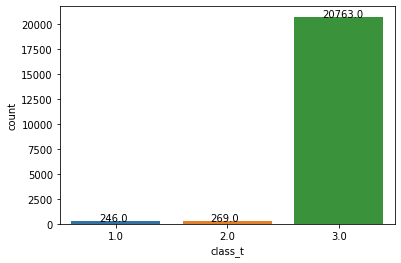

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x="class_t",data=train_df)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.savefig("560_MHz")
plt.show()

In [26]:
from sklearn.utils import shuffle
 
train_df = shuffle(train_df) # we are shuffling the data.
train_x = train_df.drop(['class_t'], axis = 1) # input data
train_y = train_df['class_t'] # output data

In [27]:
print("Input dim "+ str(train_x.shape)) # input
print("output dim: "+ str(train_y.shape)) # output

Input dim (21278, 34)
output dim: (21278,)


In [28]:
from sklearn.ensemble import RandomForestClassifier # a ML model
from sklearn.metrics import classification_report # this package is used to assess the accuracy of the ML models


In [29]:
forest = RandomForestClassifier(random_state=0)
forest.fit(train_x, train_y) # train the ML model on the training data

RandomForestClassifier(random_state=0)

In [30]:
y_pred = forest.predict(train_x)

In [31]:
print(classification_report (train_y, y_pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       246
         2.0       1.00      1.00      1.00       269
         3.0       1.00      1.00      1.00     20763

    accuracy                           1.00     21278
   macro avg       1.00      1.00      1.00     21278
weighted avg       1.00      1.00      1.00     21278



In [32]:
sources_full_560[560]["class"] = model_pre.test(forest, sources_full_560[560]) # add the predicted output to the source df

/shared/venv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [33]:
sources_full_560[560]

,Source_id,Isl_id,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,...,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,n_gaussians,class
0,0,1,0.166867,0.000023,-30.063114,0.000031,0.000007,1.066588e-06,0.000004,4.078056e-07,...,18.581804,0.000004,7.053197e-07,3.804431e-07,-3.003903e-07,1.658594e-07,-2.947291e-07,S,1,3.0
1,1,2,0.166264,0.000013,-29.997644,0.000005,0.000039,1.363236e-06,0.000015,3.808378e-07,...,2.050022,0.000034,9.722034e-07,3.872934e-07,-3.003903e-07,2.876077e-07,-2.870694e-07,S,1,3.0
2,2,3,0.166741,0.000004,-29.929983,0.000004,0.000018,6.739539e-07,0.000017,3.756164e-07,...,15.629662,0.000016,5.959697e-07,3.711908e-07,-3.003903e-07,3.405938e-07,-2.253966e-07,S,1,3.0
3,3,4,0.166679,0.000011,-29.914104,0.000010,0.000011,8.967495e-07,0.000008,4.199568e-07,...,56.068506,0.000009,6.532317e-07,3.960042e-07,-3.003903e-07,1.504303e-07,-2.935595e-07,S,1,3.0
4,4,6,0.166760,0.000002,-29.902462,0.000002,0.000050,8.223619e-07,0.000041,4.094394e-07,...,2.177424,0.000043,7.161526e-07,3.945944e-07,-3.003903e-07,5.952346e-07,-8.631091e-08,S,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47763,47763,45085,359.159607,0.000004,-29.844115,0.000004,0.000035,1.018729e-06,0.000029,5.082550e-07,...,4.335118,0.000025,6.689310e-07,4.902516e-07,-3.003903e-07,2.956740e-07,-2.463229e-07,S,1,3.0
47764,47764,45086,359.161111,0.000013,-29.676486,0.000013,0.000013,1.235509e-06,0.000009,5.652737e-07,...,16.984739,0.000010,6.992036e-07,5.333623e-07,-3.003903e-07,1.592619e-07,-2.946202e-07,S,1,3.0
47765,47765,45087,359.162660,0.000039,-29.504308,0.000044,0.000007,1.633336e-06,0.000004,6.242857e-07,...,21.033349,0.000005,8.352046e-07,5.898453e-07,-3.003903e-07,1.306260e-09,-3.011980e-07,S,1,3.0
47766,47766,45088,359.164066,0.000028,-29.326194,0.000037,0.000008,1.729929e-06,0.000005,7.061735e-07,...,40.250241,0.000005,8.948565e-07,6.558296e-07,-3.003903e-07,8.980310e-09,-3.003809e-07,S,1,3.0


In [34]:
from source.path import full_truth_path, write_df_to_disk, submission_df_path, score_report_path, image_path
from ska_sdc import Sdc1Scorer
import os
from pathlib import Path


In [35]:
# 6) Create final catalogues and calculate scores
print("\nStep 6: Final score")
for freq, source_df in sources_full_560.items():
    # Assemble submission and truth catalogues for scoring
    sub_cat_df = cat_df_from_srl_df(source_df, guess_class=False)
    truth_cat_df = load_truth_df(full_truth_path(freq), skiprows=0)
    
    # (Optional) Write final submission catalogue to disk
    write_df_to_disk(sub_cat_df, submission_df_path(freq))

    # Calculate score
    scorer = Sdc1Scorer(sub_cat_df, truth_cat_df, freq)
    score = scorer.run(mode=0, train=False, detail=True) # train=False -> means that we are removing the training data from the evaluation, so there is no data leakage

    # Write short score report:
    score_path = score_report_path(freq)
    score_dir = os.path.dirname(score_path)
    Path(score_dir).mkdir(parents=True, exist_ok=True)

    with open(score_path, "w+") as report:
        report.write(
            "Image: {}, frequency: {} MHz\n".format(image_path(freq), freq)
        )
        report.write("Score was {}\n".format(score.value))
        report.write("Number of detections {}\n".format(score.n_det))
        report.write("Number of matches {}\n".format(score.n_match))
        report.write(
            "Number of matches too far from truth {}\n".format(score.n_bad)
        )
        report.write("Number of false detections {}\n".format(score.n_false))
        report.write("Score for all matches {}\n".format(score.score_det))
        report.write("Accuracy percentage {}\n".format(score.acc_pc))
        report.write("Classification report: \n")
        report.write(
            classification_report(
                score.match_df["class_t"],
                score.match_df["class"],
                labels=[1, 2, 3],
                target_names=["1 (SS-AGN)", "2 (FS-AGN)", "3 (SFG)"],
                digits=4,
            )
        )

print("\nComplete")


Step 6: Final score


2025-03-21 11:01:16,936 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 11:01:16,938 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 11:01:20,921 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 3.98s
2025-03-21 11:01:30,372 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 9.45s
2025-03-21 11:01:30,375 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 13.44s
2025-03-21 11:01:30,473 [MainThread  ][INFO ] Sieving complete. Elapsed time: 13.54s
2025-03-21 11:01:30,537 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 13.60s
2025-03-21 11:01:30,538 [MainThread  ][INFO ] Final score: 17232.57



Complete


In [67]:
from sklearn.ensemble import RandomForestClassifier  # a ML model
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import os
from pathlib import Path

# List of classifiers to be used
classifiers = {
    "RandomForest": RandomForestClassifier(random_state=0),
    "SVM": SVC(random_state=0),
    "GradientBoosting": GradientBoostingClassifier(random_state=0),
    "NaiveBayes": GaussianNB()
}

# Process each classifier
for classifier_name, classifier in classifiers.items():
    print(f"\nTraining {classifier_name} Classifier")

    # Train the classifier
    classifier.fit(train_x, train_y)

    # Make predictions and add to the source dataframe
    sources_full_560[560]["class"] = model_pre.test(classifier, sources_full_560[560])

    # Evaluate the classifier
    y_pred = classifier.predict(train_x)
    print(f"Classification Report for {classifier_name}:\n")
#    print(classification_report(train_y, y_pred))

    # Save the results (score calculation and report writing)
    for freq, source_df in sources_full_560.items():
        # Assemble submission and truth catalogues for scoring
        sub_cat_df = cat_df_from_srl_df(source_df, guess_class=False)
        truth_cat_df = load_truth_df(full_truth_path(freq), skiprows=0)

        # (Optional) Write final submission catalogue to disk
        write_df_to_disk(sub_cat_df, submission_df_path(freq))

        # Calculate score
        scorer = Sdc1Scorer(sub_cat_df, truth_cat_df, freq)
        score = scorer.run(mode=0, train=False, detail=True)  # train=False -> removing the training data

        # Write short score report:
        # Combine `freq`, `classifier_name`, and some other relevant information to create a unique score path
        score_path = score_report_path(f"{freq}_{classifier_name}")  # Concatenate freq and classifier_name
        score_dir = os.path.dirname(score_path)
        Path(score_dir).mkdir(parents=True, exist_ok=True)

        with open(score_path, "w+") as report:
            report.write(
                f"Image: {image_path(freq)}, frequency: {freq} MHz\n"
            )
            report.write(f"Classifier: {classifier_name}\n")  # Added classifier name to the report
            report.write(f"Score was {score.value}\n")
            report.write(f"Number of detections {score.n_det}\n")
            report.write(f"Number of matches {score.n_match}\n")
            report.write(f"Number of matches too far from truth {score.n_bad}\n")
            report.write(f"Number of false detections {score.n_false}\n")
            report.write(f"Score for all matches {score.score_det}\n")
            report.write(f"Accuracy percentage {score.acc_pc}\n")
            report.write("Classification report: \n")
            report.write(
                classification_report(
                    score.match_df["class_t"],
                    score.match_df["class"],
                    labels=[1, 2, 3],
                    target_names=["1 (SS-AGN)", "2 (FS-AGN)", "3 (SFG)"],
                    digits=4,
                )
            )

print("\nComplete")



Training RandomForest Classifier


/shared/venv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Classification Report for RandomForest:



2025-03-21 12:56:45,109 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 12:56:45,110 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 12:56:49,499 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 4.39s
2025-03-21 12:56:59,420 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 9.92s
2025-03-21 12:56:59,424 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 14.31s
2025-03-21 12:56:59,523 [MainThread  ][INFO ] Sieving complete. Elapsed time: 14.41s
2025-03-21 12:56:59,585 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 14.47s
2025-03-21 12:56:59,585 [MainThread  ][INFO ] Final score: 17330.71
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/


Training SVM Classifier
Classification Report for SVM:



2025-03-21 12:57:11,672 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 12:57:11,673 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 12:57:16,045 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 4.37s
2025-03-21 12:57:25,864 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 9.82s
2025-03-21 12:57:25,867 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 14.19s
2025-03-21 12:57:25,965 [MainThread  ][INFO ] Sieving complete. Elapsed time: 14.29s
2025-03-21 12:57:26,027 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 14.35s
2025-03-21 12:57:26,028 [MainThread  ][INFO ] Final score: 17341.71
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/


Training GradientBoosting Classifier


/shared/venv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Classification Report for GradientBoosting:



2025-03-21 12:57:38,178 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 12:57:38,179 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 12:57:42,603 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 4.42s
2025-03-21 12:57:52,495 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 9.89s
2025-03-21 12:57:52,499 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 14.32s
2025-03-21 12:57:52,599 [MainThread  ][INFO ] Sieving complete. Elapsed time: 14.42s
2025-03-21 12:57:52,661 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 14.48s
2025-03-21 12:57:52,662 [MainThread  ][INFO ] Final score: 17338.28
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/


Training NaiveBayes Classifier
Classification Report for NaiveBayes:



2025-03-21 12:58:04,738 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 12:58:04,739 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 12:58:09,078 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 4.34s
2025-03-21 12:58:19,352 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 10.27s
2025-03-21 12:58:19,356 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 14.62s
2025-03-21 12:58:19,454 [MainThread  ][INFO ] Sieving complete. Elapsed time: 14.71s
2025-03-21 12:58:19,514 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 14.77s
2025-03-21 12:58:19,515 [MainThread  ][INFO ] Final score: 17212.85



Complete


/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 9200 MHz Frequency image

In [37]:
%store -r sources_training_9200
%store -r sources_full_9200

In [38]:
sources_training_9200[9200]

,Source_id,Isl_id,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,...,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,n_gaussians
0,0,1,359.994776,3.794498e-08,-29.939449,3.688472e-08,0.000022,1.270335e-07,2.096340e-05,7.130223e-08,...,90.501608,9.693534,2.228822e-05,1.602706e-07,7.058140e-08,3.515880e-09,1.119012e-07,6.184984e-08,S,1
1,1,2,359.993439,2.663387e-06,-29.934651,4.327856e-06,0.000001,3.162681e-07,4.414545e-07,7.824039e-08,...,4.336756,27.352771,9.887885e-07,1.338088e-07,7.538082e-08,2.258710e-09,4.253214e-08,7.363560e-09,S,1
2,2,3,359.987203,9.303846e-07,-29.939105,9.838801e-07,0.000001,1.423846e-07,9.032695e-07,7.058436e-08,...,140.997165,23.475566,1.048454e-06,1.280567e-07,6.767367e-08,1.958670e-09,2.139782e-08,2.054480e-09,S,1
3,3,6,359.966864,2.668586e-06,-29.920252,3.001088e-06,0.000002,4.194308e-07,8.536816e-07,1.475009e-07,...,38.434159,25.302217,1.775063e-06,2.217805e-07,1.381258e-07,8.765600e-09,7.919645e-08,-1.085669e-07,S,1
4,4,7,359.966814,4.638866e-06,-29.920272,3.319966e-06,0.000002,5.938459e-07,7.475197e-07,1.415977e-07,...,63.449312,25.005422,1.705945e-06,2.220623e-07,1.383013e-07,8.462220e-09,4.208926e-08,-2.592590e-08,S,1
5,5,8,359.963753,3.730365e-06,-29.926580,2.527745e-06,0.000001,3.717866e-07,6.439050e-07,1.223302e-07,...,74.687949,32.619141,1.013065e-06,1.613971e-07,1.139775e-07,-4.253330e-09,3.383509e-08,2.772740e-09,S,1
6,6,9,359.961863,4.960924e-06,-29.934943,2.535850e-06,0.000003,4.955295e-07,5.963324e-07,8.863696e-08,...,78.291159,16.278079,1.537895e-06,1.875637e-07,9.366069e-08,3.070900e-09,4.735860e-08,3.276980e-09,S,1
7,7,10,359.960132,2.126318e-06,-29.915611,2.370905e-06,0.000004,6.816870e-07,1.621925e-06,2.003956e-07,...,141.724525,19.256031,3.702513e-05,1.179960e-06,1.887007e-07,1.963315e-08,2.229581e-07,9.848548e-07,S,1


In [39]:
print(sources_training_9200[9200].shape)

(8, 46)


In [40]:
from source.utils.bdsf_utils import  load_truth_df, cat_df_from_srl_df 
from source.path import train_truth_path, full_truth_path, write_df_to_disk, submission_df_path
from source.utils.columns import SRL_CAT_COLS, SRL_COLS_TO_DROP, SRL_NUM_COLS
from source.utils.classification import SKLClassification

In [41]:
model_pre = SKLClassification()
train_truth_cat_df = load_truth_df(train_truth_path(9200), skiprows=18) # the tuth cataluge for the training data

"""
Args:
    srl_df (:obj:`pandas.DataFrame`): Source list.
    truth_cat_df (:obj:`pandas.DataFrame`): Truth catalogue.
    regressand_col: (`str`): Regressand column name (output).
    freq: (`int`): Frequency band (MHz).
Returns:
    srl_df (`str`): Crossmatched source list DataFrame used for training.
"""
train_df = model_pre.pre_process(sources_training_9200[9200], train_truth_cat_df, regressand_col="class_t", freq=9200)

2025-03-21 11:06:02,811 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 11:06:02,811 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 11:06:02,845 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.03s
2025-03-21 11:06:02,860 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.01s
2025-03-21 11:06:02,861 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.05s
2025-03-21 11:06:02,876 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.07s
2025-03-21 11:06:02,914 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.10s
2025-03-21 11:06:02,915 [MainThread  ][INFO ] Final score: 2.02


In [42]:
train_df

,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,Maj,E_Maj,Min,E_Min,Maj_img_plane,E_Maj_img_plane,...,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,n_gaussians,class_t
Source_id,,,,,,,,,,,,,,,,,,,,,
0,0.000022,1.270335e-07,2.096340e-05,7.130223e-08,0.000026,8.935384e-08,0.000026,8.685660e-08,0.000026,8.935384e-08,...,9.693534,2.228822e-05,1.602706e-07,7.058140e-08,3.515880e-09,1.119012e-07,6.184984e-08,0,1.0,2.0
1,0.000001,3.162681e-07,4.414545e-07,7.824039e-08,0.000053,1.020962e-05,0.000038,6.241971e-06,0.000053,1.020962e-05,...,27.352771,9.887885e-07,1.338088e-07,7.538082e-08,2.258710e-09,4.253214e-08,7.363560e-09,0,1.0,3.0
2,0.000001,1.423846e-07,9.032695e-07,7.058436e-08,0.000030,2.539714e-06,0.000026,1.928130e-06,0.000030,2.539714e-06,...,23.475566,1.048454e-06,1.280567e-07,6.767367e-08,1.958670e-09,2.139782e-08,2.054480e-09,0,1.0,2.0
4,0.000002,5.938459e-07,7.475197e-07,1.415977e-07,0.000056,1.177699e-05,0.000038,6.461404e-06,0.000056,1.177699e-05,...,25.005422,1.705945e-06,2.220623e-07,1.383013e-07,8.462220e-09,4.208926e-08,-2.592590e-08,0,1.0,3.0
5,0.000001,3.717866e-07,6.439050e-07,1.223302e-07,0.000043,8.974786e-06,0.000033,5.661164e-06,0.000043,8.974786e-06,...,32.619141,1.013065e-06,1.613971e-07,1.139775e-07,-4.253330e-09,3.383509e-08,2.772740e-09,0,1.0,3.0
6,0.000003,4.955295e-07,5.963324e-07,8.863696e-08,0.000072,1.187417e-05,0.000042,5.579772e-06,0.000072,1.187417e-05,...,16.278079,1.537895e-06,1.875637e-07,9.366069e-08,3.070900e-09,4.735860e-08,3.276980e-09,0,1.0,3.0


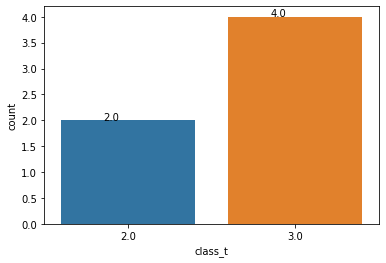

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x="class_t",data=train_df)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.savefig("9200_MHz")
plt.show()

In [44]:
from sklearn.utils import shuffle
 
train_df = shuffle(train_df) # we are shuffling the data.
train_x = train_df.drop(['class_t'], axis = 1) # input data
train_y = train_df['class_t'] # output data

In [45]:
print("Input dim "+ str(train_x.shape)) # input
print("output dim: "+ str(train_y.shape)) # output

Input dim (6, 34)
output dim: (6,)


In [46]:
from sklearn.ensemble import RandomForestClassifier # a ML model
from sklearn.metrics import classification_report # this package is used to assess the accuracy of the ML models


In [47]:
forest = RandomForestClassifier(random_state=0)
forest.fit(train_x, train_y) # train the ML model on the training data

RandomForestClassifier(random_state=0)

In [48]:
y_pred = forest.predict(train_x)

In [49]:
print(classification_report (train_y, y_pred))

              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         2
         3.0       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [50]:
sources_full_9200[9200]["class"] = model_pre.test(forest, sources_full_9200[9200]) # add the predicted output to the source df

/shared/venv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [51]:
sources_full_9200[9200]

,Source_id,Isl_id,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,...,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,n_gaussians,class
0,0,0,0.008159,3.126320e-06,-29.944960,3.017018e-06,1.472397e-06,2.711526e-07,4.342720e-07,6.327748e-08,...,21.819057,9.729385e-07,1.143387e-07,6.167017e-08,-2.311450e-09,8.963370e-09,-2.304920e-09,S,1,3.0
1,1,1,0.006769,3.748570e-09,-29.912127,3.741120e-09,5.006450e-04,2.886138e-07,4.749584e-04,1.608568e-07,...,11.440571,5.013952e-04,4.250543e-07,1.588353e-07,3.928570e-09,2.611140e-07,9.508095e-08,S,1,3.0
2,2,2,0.001738,1.208647e-07,-29.909088,1.209694e-07,1.544330e-05,2.990963e-07,1.537048e-05,1.721354e-07,...,36.504293,1.539093e-05,3.381163e-07,1.719380e-07,-1.050676e-08,1.272682e-07,1.753273e-08,S,1,3.0
3,3,3,0.000007,4.286420e-06,-29.944330,1.250137e-06,1.685244e-05,7.515139e-07,9.536618e-07,4.026466e-08,...,3.266001,1.616547e-05,4.038480e-07,7.114005e-08,6.299400e-10,6.854138e-08,4.188170e-09,S,1,3.0
4,4,5,359.994776,3.819453e-08,-29.939449,3.712725e-08,2.186599e-05,1.278696e-07,2.096341e-05,7.177027e-08,...,9.756564,2.228822e-05,1.613217e-07,7.104428e-08,3.376500e-09,1.119559e-07,6.174496e-08,S,1,3.0
5,5,7,359.993439,2.673825e-06,-29.934651,4.337877e-06,1.404777e-06,3.187780e-07,4.428099e-07,7.850130e-08,...,27.410773,9.887885e-07,1.343488e-07,7.568500e-08,7.691700e-10,4.247374e-08,5.863280e-09,S,1,3.0
6,6,9,359.990660,3.999801e-06,-29.945612,2.463251e-06,1.986251e-06,3.056650e-07,4.509566e-07,5.733369e-08,...,13.467132,1.402537e-06,1.265508e-07,6.005812e-08,1.086590e-09,2.307481e-08,1.219990e-09,S,1,3.0
7,7,10,359.987203,9.325032e-07,-29.939105,9.860593e-07,1.131552e-06,1.430104e-07,9.046499e-07,7.073815e-08,...,23.481198,1.048454e-06,1.282674e-07,6.778503e-08,3.558600e-10,2.140510e-08,4.547000e-10,S,1,3.0
8,8,11,359.986302,1.504253e-06,-29.942300,3.282264e-06,1.369023e-06,2.279430e-07,5.876337e-07,7.031187e-08,...,10.497752,1.157450e-06,1.294463e-07,6.981867e-08,4.475110e-09,1.674202e-08,4.781990e-09,S,1,3.0
9,9,13,359.978448,3.351213e-06,-29.941874,1.440288e-06,8.256790e-07,1.884974e-07,5.004648e-07,7.486087e-08,...,14.299854,6.832301e-07,1.176512e-07,7.327363e-08,1.136630e-09,2.674694e-08,8.789220e-09,S,1,3.0


In [52]:
from source.path import full_truth_path, write_df_to_disk, submission_df_path, score_report_path, image_path
from ska_sdc import Sdc1Scorer
import os
from pathlib import Path


In [53]:
# 6) Create final catalogues and calculate scores
print("\nStep 6: Final score")
for freq, source_df in sources_full_9200.items():
    # Assemble submission and truth catalogues for scoring
    sub_cat_df = cat_df_from_srl_df(source_df, guess_class=False)
    truth_cat_df = load_truth_df(full_truth_path(freq), skiprows=0)
    
    # (Optional) Write final submission catalogue to disk
    write_df_to_disk(sub_cat_df, submission_df_path(freq))

    # Calculate score
    scorer = Sdc1Scorer(sub_cat_df, truth_cat_df, freq)
    score = scorer.run(mode=0, train=False, detail=True) # train=False -> means that we are removing the training data from the evaluation, so there is no data leakage

    # Write short score report:
    score_path = score_report_path(freq)
    score_dir = os.path.dirname(score_path)
    Path(score_dir).mkdir(parents=True, exist_ok=True)

    with open(score_path, "w+") as report:
        report.write(
            "Image: {}, frequency: {} MHz\n".format(image_path(freq), freq)
        )
        report.write("Score was {}\n".format(score.value))
        report.write("Number of detections {}\n".format(score.n_det))
        report.write("Number of matches {}\n".format(score.n_match))
        report.write(
            "Number of matches too far from truth {}\n".format(score.n_bad)
        )
        report.write("Number of false detections {}\n".format(score.n_false))
        report.write("Score for all matches {}\n".format(score.score_det))
        report.write("Accuracy percentage {}\n".format(score.acc_pc))
        report.write("Classification report: \n")
        report.write(
            classification_report(
                score.match_df["class_t"],
                score.match_df["class"],
                labels=[1, 2, 3],
                target_names=["1 (SS-AGN)", "2 (FS-AGN)", "3 (SFG)"],
                digits=4,
            )
        )

print("\nComplete")


Step 6: Final score


2025-03-21 11:06:03,860 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 11:06:03,861 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 11:06:03,927 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.07s
2025-03-21 11:06:04,020 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.09s
2025-03-21 11:06:04,021 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.16s
2025-03-21 11:06:04,037 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.18s
2025-03-21 11:06:04,076 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.22s
2025-03-21 11:06:04,077 [MainThread  ][INFO ] Final score: 3.98



Complete


/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
from sklearn.ensemble import RandomForestClassifier  # a ML model
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import os
from pathlib import Path

# List of classifiers to be used
classifiers = {
    "RandomForest": RandomForestClassifier(random_state=0),
    "SVM": SVC(random_state=0),
    "GradientBoosting": GradientBoostingClassifier(random_state=0),
    "NaiveBayes": GaussianNB()
}

# Process each classifier
for classifier_name, classifier in classifiers.items():
    print(f"\nTraining {classifier_name} Classifier")

    # Train the classifier
    classifier.fit(train_x, train_y)

    # Make predictions and add to the source dataframe
    sources_full_9200[9200]["class"] = model_pre.test(classifier, sources_full_9200[9200])

    # Evaluate the classifier
    y_pred = classifier.predict(train_x)
    print(f"Classification Report for {classifier_name}:\n")
 #   print(classification_report(train_y, y_pred))

    # Save the results (score calculation and report writing)
    for freq, source_df in sources_full_9200.items():
        # Assemble submission and truth catalogues for scoring
        sub_cat_df = cat_df_from_srl_df(source_df, guess_class=False)
        truth_cat_df = load_truth_df(full_truth_path(freq), skiprows=0)

        # (Optional) Write final submission catalogue to disk
        write_df_to_disk(sub_cat_df, submission_df_path(freq))

        # Calculate score
        scorer = Sdc1Scorer(sub_cat_df, truth_cat_df, freq)
        score = scorer.run(mode=0, train=False, detail=True)  # train=False -> removing the training data

        # Write short score report:
        # Combine `freq`, `classifier_name`, and some other relevant information to create a unique score path
        score_path = score_report_path(f"{freq}_{classifier_name}")  # Concatenate freq and classifier_name
        score_dir = os.path.dirname(score_path)
        Path(score_dir).mkdir(parents=True, exist_ok=True)

        with open(score_path, "w+") as report:
            report.write(
                f"Image: {image_path(freq)}, frequency: {freq} MHz\n"
            )
            report.write(f"Classifier: {classifier_name}\n")  # Added classifier name to the report
            report.write(f"Score was {score.value}\n")
            report.write(f"Number of detections {score.n_det}\n")
            report.write(f"Number of matches {score.n_match}\n")
            report.write(f"Number of matches too far from truth {score.n_bad}\n")
            report.write(f"Number of false detections {score.n_false}\n")
            report.write(f"Score for all matches {score.score_det}\n")
            report.write(f"Accuracy percentage {score.acc_pc}\n")
            report.write("Classification report: \n")
            report.write(
                classification_report(
                    score.match_df["class_t"],
                    score.match_df["class"],
                    labels=[1, 2, 3],
                    target_names=["1 (SS-AGN)", "2 (FS-AGN)", "3 (SFG)"],
                    digits=4,
                )
            )

print("\nComplete")



Training RandomForest Classifier
Classification Report for RandomForest:



/shared/venv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
2025-03-21 13:00:19,903 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 13:00:19,903 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 13:00:19,970 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.07s
2025-03-21 13:00:20,066 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.10s
2025-03-21 13:00:20,067 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.16s
2025-03-21 13:00:20,084 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.18s
2025-03-21 13:00:20,123 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.22s
2025-03-21 13:00:20,123 [MainThread  ][INFO ] Final score: 3.98
/shared/venv/lib/python3.10/s


Training SVM Classifier
Classification Report for SVM:



2025-03-21 13:00:20,389 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.07s
2025-03-21 13:00:20,486 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.10s
2025-03-21 13:00:20,487 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.17s
2025-03-21 13:00:20,503 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.18s
2025-03-21 13:00:20,543 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.22s
2025-03-21 13:00:20,543 [MainThread  ][INFO ] Final score: 3.98
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l


Training GradientBoosting Classifier
Classification Report for GradientBoosting:



2025-03-21 13:00:20,781 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 13:00:20,782 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 13:00:20,850 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.07s
2025-03-21 13:00:20,945 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.09s
2025-03-21 13:00:20,946 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.16s
2025-03-21 13:00:20,962 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.18s
2025-03-21 13:00:21,001 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.22s
2025-03-21 13:00:21,001 [MainThread  ][INFO ] Final score: 3.98
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/


Training NaiveBayes Classifier
Classification Report for NaiveBayes:



2025-03-21 13:00:21,268 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.07s
2025-03-21 13:00:21,362 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.09s
2025-03-21 13:00:21,363 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.16s
2025-03-21 13:00:21,379 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.18s
2025-03-21 13:00:21,418 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.22s
2025-03-21 13:00:21,419 [MainThread  ][INFO ] Final score: 3.98



Complete


/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier  # a ML model
import os
from pathlib import Path

# List of classifiers to be used
classifiers = {
    "RandomForest": RandomForestClassifier(random_state=0),
    "LogisticRegression": LogisticRegression(random_state=0),
    "SVM": SVC(random_state=0),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=0),
    "GradientBoosting": GradientBoostingClassifier(random_state=0),
    "NaiveBayes": GaussianNB()
}

# Process each classifier
for classifier_name, classifier in classifiers.items():
    print(f"\nTraining {classifier_name} Classifier")

    # Train the classifier
    classifier.fit(train_x, train_y)

    # Make predictions and add to the source dataframe
    sources_full_9200[9200]["class"] = model_pre.test(classifier, sources_full_9200[9200])

    # Evaluate the classifier
    y_pred = classifier.predict(train_x)
    print(f"Classification Report for {classifier_name}:\n")
    print(classification_report(train_y, y_pred))

    # Save the results (score calculation and report writing)
    for freq, source_df in sources_full_9200.items():
        # Assemble submission and truth catalogues for scoring
        sub_cat_df = cat_df_from_srl_df(source_df, guess_class=False)
        truth_cat_df = load_truth_df(full_truth_path(freq), skiprows=0)

        # (Optional) Write final submission catalogue to disk
        write_df_to_disk(sub_cat_df, submission_df_path(freq))

        # Calculate score
        scorer = Sdc1Scorer(sub_cat_df, truth_cat_df, freq)
        score = scorer.run(mode=0, train=False, detail=True)  # train=False -> removing the training data

        # Write short score report:
        # Combine `freq`, `classifier_name`, and some other relevant information to create a unique score path
        score_path = score_report_path(f"{freq}_{classifier_name}")  # Concatenate freq and classifier_name
        score_dir = os.path.dirname(score_path)
        Path(score_dir).mkdir(parents=True, exist_ok=True)

        with open(score_path, "w+") as report:
            report.write(
                f"Image: {image_path(freq)}, frequency: {freq} MHz\n"
            )
            report.write(f"Classifier: {classifier_name}\n")  # Added classifier name to the report
            report.write(f"Score was {score.value}\n")
            report.write(f"Number of detections {score.n_det}\n")
            report.write(f"Number of matches {score.n_match}\n")
            report.write(f"Number of matches too far from truth {score.n_bad}\n")
            report.write(f"Number of false detections {score.n_false}\n")
            report.write(f"Score for all matches {score.score_det}\n")
            report.write(f"Accuracy percentage {score.acc_pc}\n")
            report.write("Classification report: \n")
            report.write(
                classification_report(
                    score.match_df["class_t"],
                    score.match_df["class"],
                    labels=[1, 2, 3],
                    target_names=["1 (SS-AGN)", "2 (FS-AGN)", "3 (SFG)"],
                    digits=4,
                )
            )

print("\nComplete")

# Pull and print accuracy results from saved text files
accuracy_results = []
for classifier_name in classifiers.keys():
    for freq in sources_full_9200.keys():
        score_path = score_report_path(f"{freq}_{classifier_name}")
        if os.path.exists(score_path):
            with open(score_path, "r") as file:
                for line in file:
                    if "Accuracy percentage" in line:
                        accuracy_results.append(f"{classifier_name} ({freq} MHz): {line.strip()}")

print("\nAccuracy Results from Saved Text Files:")
for result in accuracy_results:
    print(result)


Training RandomForest Classifier
Classification Report for RandomForest:

              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         2
         3.0       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



/shared/venv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
2025-03-21 11:44:17,887 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 11:44:17,888 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 11:44:17,955 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.07s
2025-03-21 11:44:18,047 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.09s
2025-03-21 11:44:18,048 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.16s
2025-03-21 11:44:18,065 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.18s
2025-03-21 11:44:18,105 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.22s
2025-03-21 11:44:18,105 [MainThread  ][INFO ] Final score: 3.98
/shared/venv/lib/python3.10/s


Training LogisticRegression Classifier
Classification Report for LogisticRegression:

              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         2
         3.0       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



2025-03-21 11:44:18,318 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 11:44:18,319 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 11:44:18,386 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.07s
2025-03-21 11:44:18,478 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.09s
2025-03-21 11:44:18,479 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.16s
2025-03-21 11:44:18,496 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.18s
2025-03-21 11:44:18,537 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.22s
2025-03-21 11:44:18,537 [MainThread  ][INFO ] Final score: 3.98
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/


Training SVM Classifier
Classification Report for SVM:

              precision    recall  f1-score   support

         2.0       1.00      0.50      0.67         2
         3.0       0.80      1.00      0.89         4

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6



2025-03-21 11:44:18,811 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.07s
2025-03-21 11:44:18,903 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.09s
2025-03-21 11:44:18,904 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.16s
2025-03-21 11:44:18,921 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.18s
2025-03-21 11:44:18,962 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.22s
2025-03-21 11:44:18,962 [MainThread  ][INFO ] Final score: 3.98
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l


Training KNN Classifier
Classification Report for KNN:

              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         2
         3.0       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6



2025-03-21 11:44:19,200 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 11:44:19,200 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 11:44:19,268 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.07s
2025-03-21 11:44:19,359 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.09s
2025-03-21 11:44:19,360 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.16s
2025-03-21 11:44:19,377 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.18s
2025-03-21 11:44:19,418 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.22s
2025-03-21 11:44:19,419 [MainThread  ][INFO ] Final score: 3.98
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/


Training DecisionTree Classifier
Classification Report for DecisionTree:

              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         2
         3.0       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



2025-03-21 11:44:19,691 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.07s
2025-03-21 11:44:19,783 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.09s
2025-03-21 11:44:19,784 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.16s
2025-03-21 11:44:19,800 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.18s
2025-03-21 11:44:19,841 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.22s
2025-03-21 11:44:19,842 [MainThread  ][INFO ] Final score: 3.98
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l


Training GradientBoosting Classifier
Classification Report for GradientBoosting:

              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         2
         3.0       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



2025-03-21 11:44:20,088 [MainThread  ][INFO ] SKAO Science Data Challenge Scoring Pipeline
2025-03-21 11:44:20,089 [MainThread  ][INFO ] Scoring pipeline started
2025-03-21 11:44:20,156 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.07s
2025-03-21 11:44:20,247 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.09s
2025-03-21 11:44:20,248 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.16s
2025-03-21 11:44:20,265 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.18s
2025-03-21 11:44:20,304 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.22s
2025-03-21 11:44:20,305 [MainThread  ][INFO ] Final score: 3.98
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/


Training NaiveBayes Classifier
Classification Report for NaiveBayes:

              precision    recall  f1-score   support

         2.0       0.67      1.00      0.80         2
         3.0       1.00      0.75      0.86         4

    accuracy                           0.83         6
   macro avg       0.83      0.88      0.83         6
weighted avg       0.89      0.83      0.84         6



2025-03-21 11:44:20,578 [MainThread  ][INFO ] Catalogue preparation complete. Elapsed time: 0.07s
2025-03-21 11:44:20,670 [MainThread  ][INFO ] [Sdc1XMatch.execute] complete in 0.09s
2025-03-21 11:44:20,671 [MainThread  ][INFO ] Crossmatch runs complete. Elapsed time: 0.16s
2025-03-21 11:44:20,687 [MainThread  ][INFO ] Sieving complete. Elapsed time: 0.18s
2025-03-21 11:44:20,728 [MainThread  ][INFO ] Scoring pipeline complete. Elapsed time: 0.22s
2025-03-21 11:44:20,728 [MainThread  ][INFO ] Final score: 3.98



Complete

Accuracy Results from Saved Text Files:
RandomForest (9200 MHz): Accuracy percentage 69.84251151374048
LogisticRegression (9200 MHz): Accuracy percentage 69.84251151374048
SVM (9200 MHz): Accuracy percentage 69.84251151374048
KNN (9200 MHz): Accuracy percentage 69.84251151374048
DecisionTree (9200 MHz): Accuracy percentage 69.84251151374048
GradientBoosting (9200 MHz): Accuracy percentage 69.84251151374048
NaiveBayes (9200 MHz): Accuracy percentage 69.84251151374048


/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Plotting the data

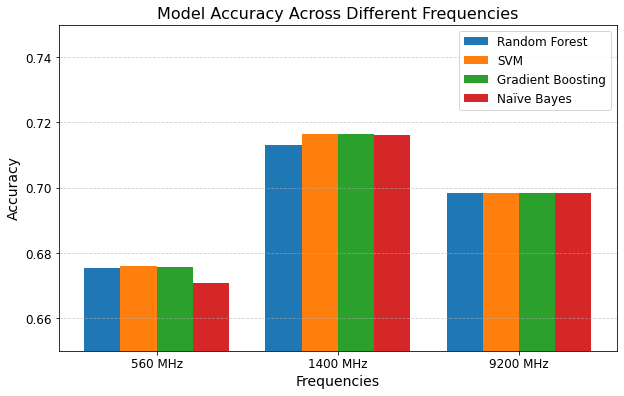

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Frequencies
frequencies = ["560 MHz", "1400 MHz", "9200 MHz"]

# Models
models = ["Random Forest", "SVM", "Gradient Boosting", "Naïve Bayes"]

# Accuracy values for each model at different frequencies
accuracy = np.array([
    [0.6754, 0.7132, 0.6984],  # Random Forest
    [0.6759, 0.7166, 0.6984],  # SVM
    [0.6757, 0.7166, 0.6984],  # Gradient Boosting
    [0.6709, 0.7163, 0.6984],  # Naïve Bayes
])

# Bar width and x locations
bar_width = 0.2
x = np.arange(len(frequencies))

# Create the figure
plt.figure(figsize=(10, 6))

# Plot bars for each model
for i, model in enumerate(models):
    plt.bar(x + i * bar_width - (bar_width * (len(models) - 1) / 2), accuracy[i], width=bar_width, label=model)

# Labels and title
plt.xlabel("Frequencies", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Model Accuracy Across Different Frequencies", fontsize=16)
plt.xticks(x, frequencies, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.ylim(0.65, 0.75)  # Adjusted for better visualization
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Save and show
plt.savefig("plot.png", dpi=300)
plt.show()
